In [1]:
!nvidia-smi

Sat Jan 27 07:08:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import warnings 
warnings.filterwarnings("ignore")

In [3]:
import tensorflow as tf
print(tf.version.VERSION)

2.13.0


In [4]:
!git clone --depth 1 -b v2.13.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2224, done.
remote: Counting objects: 100% (2224/2224), done.
remote: Compressing objects: 100% (1594/1594), done.
remote: Total 2224 (delta 713), reused 1018 (delta 594), pack-reused 0
Receiving objects: 100% (2224/2224), 18.47 MiB | 26.98 MiB/s, done.
Resolving deltas: 100% (713/713), done.
Note: switching to '6db73770b90aca5e8110478aed79b0fc5d06355c'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false



In [5]:
!pip install -q six google-api-python-client kaggle numpy oauth2client pandas psutil py-cpuinfo scipy tensorflow-hub tensorflow-model-optimization tensorflow-datasets gin-config tf_slim Cython matplotlib pyyaml opencv-python-headless Pillow pycocotools seqeval sentencepiece sacrebleu immutabledict

In [6]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.tools import tokenization
from official.nlp import optimization

In [7]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.13.0
Eager mode:  True
Hub version:  0.14.0
GPU is available


In [8]:
df = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text-dataset/Training_Essay_Data.csv")

In [9]:
df.shape

(29145, 2)

In [10]:
df["text"] = df['text'].str.lower()

In [11]:
df.head(5)

,text,generated
0,car-free cities have become a subject of incre...,1
1,"car free cities car-free cities, a concept ga...",1
2,a sustainable urban future car-free cities ...,1
3,pioneering sustainable urban living in an e...,1
4,the path to sustainable urban living in an ...,1


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

(array([17508.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 11637.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

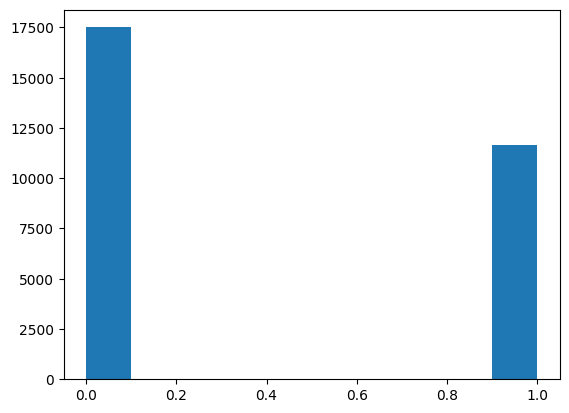

In [13]:
plt.hist(df['generated'])

In [14]:
train_df, remaining = train_test_split(df, random_state = 42, train_size= 0.040, stratify=df.generated.values)
valid_df, _ = train_test_split(remaining, random_state=42, train_size=0.010, stratify=remaining.generated.values)
train_df.shape, valid_df.shape

((1165, 2), (279, 2))

In [15]:
with tf.device('/cpu:0'):

 train_data = tf.data.Dataset.from_tensor_slices((train_df["text"].values, train_df["generated"].values))
 valid_data = tf.data.Dataset.from_tensor_slices((valid_df.text.values, valid_df.generated.values))

 for text, labels in train_data.take(1):
   print(text)
   print(labels)

tf.Tensor(b'many people agree in abolishing the electoral college. electoral collage caused a dispute in the year 2000. the electoral college is a irrational system and it should be banned.\n\ncertainly the electoral college has some benefits. in the passage "in defense of the electoral college: five reasons to keep our sidpised method of choosing the president" by richard a. posner the author states that the electoral college "avoids the problem of elections in which no candidate receives a majority of votes cast." with the electoral college there is no issue of a candidate getting the most votes, so there wont have to be any runoff elections. runoff elections complicated the election process. posner asserts that the "winning candidate\'s share of the electoral college invariably exceeds his share of the popular vote." it is because of this that the possibility of an argument over the outcome of an electoral college is lesser then an argument over the popular vote. although this is tr

In [18]:
list_labels = [0,1] # Label categories
max_seq_length = 512 # maximum length of (token) input sequences
train_batch_size = 2
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [19]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=list_labels, max_seq_length=max_seq_length, tokenizer=tokenizer):
  text_a = text.numpy()
  labels = label.numpy()
  example = classifier_data_lib.InputExample(guid=None,
                                             text_a=text_a,
                                             text_b=None,
                                             label=labels)
  feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)

  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)



In [20]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text,label],
                                                                Tout=[tf.int32,tf.int32,tf.int32,tf.int32])

  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
      "input_word_ids":input_ids,
      "input_mask":input_mask,
      "input_type_ids":segment_ids
  }

  return (x, label_id)

In [21]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(100).batch(2, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data = (valid_data.map(to_feature_map,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(100).batch(2, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE))


In [22]:
# train data spec
train_data.element_spec

({'input_word_ids': TensorSpec(shape=(2, 512), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(2, 512), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(2, 512), dtype=tf.int32, name=None)},
 TensorSpec(shape=(2,), dtype=tf.int32, name=None))

In [23]:
# train data spec
train_data.element_spec

({'input_word_ids': TensorSpec(shape=(2, 512), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(2, 512), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(2, 512), dtype=tf.int32, name=None)},
 TensorSpec(shape=(2,), dtype=tf.int32, name=None))

In [24]:
# Building the model
def create_model():

  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
  input_type_id = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_type_ids")
  pooled_output, sequence_output = bert_layer([input_word_ids,input_mask,input_type_id])

  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(drop)

  model = tf.keras.Model(
      {
          "input_word_ids": input_word_ids,
          "input_mask": input_mask,
          "input_type_ids":input_type_id
      },
      outputs=output)
  return model

In [25]:
model = create_model()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = tf.keras.metrics.BinaryAccuracy())
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 512)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                              

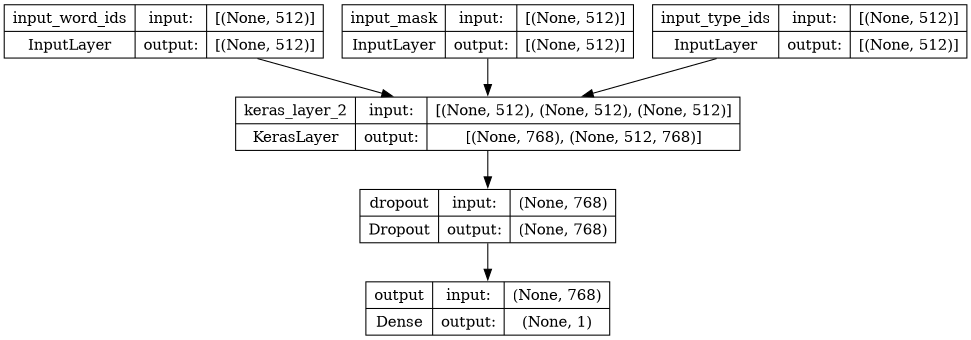

In [26]:
tf.keras.utils.plot_model(model=model,show_shapes=True, dpi=76)

In [27]:
# Train model
epochs = 4
history = model.fit(train_data,
          validation_data = valid_data,
          epochs = epochs,
          verbose = 1)

Epoch 1/4
582/582 [==============================] - 243s 344ms/step - loss: 0.1725 - binary_accuracy: 0.9356 - val_loss: 0.0622 - val_binary_accuracy: 0.9820
Epoch 2/4
582/582 [==============================] - 181s 309ms/step - loss: 0.0752 - binary_accuracy: 0.9759 - val_loss: 0.0712 - val_binary_accuracy: 0.9748
Epoch 3/4
582/582 [==============================] - 177s 302ms/step - loss: 0.0338 - binary_accuracy: 0.9897 - val_loss: 0.0564 - val_binary_accuracy: 0.9856
Epoch 4/4
582/582 [==============================] - 176s 300ms/step - loss: 0.0059 - binary_accuracy: 0.9983 - val_loss: 0.0278 - val_binary_accuracy: 0.9964


In [28]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

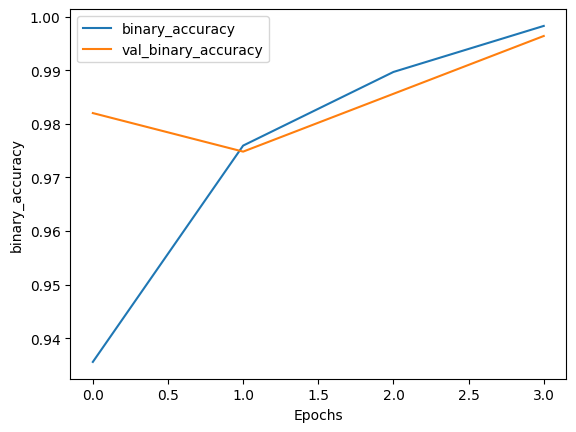

In [29]:
plot_graphs(history, 'binary_accuracy')

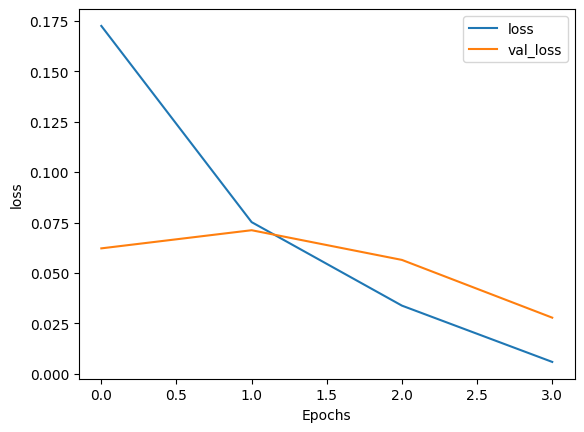

In [30]:
plot_graphs(history, 'loss')

In [31]:
model.evaluate(valid_data, verbose=1)

139/139 [==============================] - 14s 88ms/step - loss: 0.0278 - binary_accuracy: 0.9964


[0.02781061641871929, 0.9964028596878052]

In [48]:
test_essays = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')


In [49]:
test_df = test_essays['text']

In [50]:
test_df.head()

0    Aaa bbb ccc.
1    Bbb ccc ddd.
2    CCC ddd eee.
Name: text, dtype: object

In [51]:
test_data = tf.data.Dataset.from_tensor_slices((test_df, [0]*len(test_df)))
test_data = (test_data.map(to_feature_map).batch(1))
preds = model.predict(test_data)

3/3 [==============================] - 0s 65ms/step


In [52]:
preds

array([[0.6159826 ],
       [0.60151464],
       [0.08089749]], dtype=float32)

In [53]:
test_essays['generated'] = preds

In [54]:
test_essays.head()

,id,prompt_id,text,generated
0,0000aaaa,2,Aaa bbb ccc.,0.615983
1,1111bbbb,3,Bbb ccc ddd.,0.601515
2,2222cccc,4,CCC ddd eee.,0.080897


In [57]:
submission_df = test_essays[['id','generated']]

In [58]:
submission_df.to_csv('submission.csv', index=False)

In [59]:
submission_df

,id,generated
0,0000aaaa,0.615983
1,1111bbbb,0.601515
2,2222cccc,0.080897
